##### Modeling pilot profile against accidents in General Aviation Single-pilot Operations


#### Data Wrangling

The data source for this project is the National Transportation Safety Board Aviation Accident database available at https://app.ntsb.gov/avdata/Access/

This is a MS Access formated database composed of 20 tables.

For the purpose of this project an initial subset of the data was filtered out of MS Access using that program's query utilities. This initial definition was meant to be broad in scope to make the dataset for the project more manageable. This was done by avoiding to export columns that clearly would not contribute to the analysis of the problem and only selecting records pertinent to the project (i.e. commercial flight operations were left out of the export.)

The following tables were condensed and exported to csv files:
- aircraft: aircraft data, type of operation (commercial, General Aviation, etc.), phase of flight
- crew_flt_time: Pilot flight hours breakdown in categories
- crew: sex, age, pilot category, medical certificate type, last check info 
- crew_ratings: pilot certifications
- events: event date, prevailing weather
- findings: enumerates causes of incidents as determined by investigation

In [91]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import re
import sys
from os.path import dirname
sys.path.append(dirname('D:\cap\capstone2\src\dicts.py'))

# external dictionaries
import dicts
import phase_codes
from datetime import datetime

In [3]:
def generate_profile(df):
    '''generate pandas profile'''
 
    profile = ProfileReport(df)   
    profile.to_widgets()
    
def info (df, column):
    '''return several descriptive items'''
    
    if column != '':
        print("UNIQUE VALUES & COUNTS IN " + column)
        print(df[column] .unique())
        print(df[column] .value_counts())
        
    print("df shape: ")
    print(df.shape)

#### Aircraft Dataset
The aircraft dataset contains information on the aircraft involved in the accident. The column 'far_part' will be used to determine under what code the flight was operating. This is were the data can be filter to include only General Aviation records and exclude commercial aviation. The column 'second_pilot' will be use to filter the data to include only single pilot operations (scope of analysis). Other remaining fields may be useful in analysis

In [4]:
file = 'D:/cap/capstone2/data/raw/aircraft.csv'
aircraft = pd.read_csv(file, encoding = 'Windows-1252', index_col = 0, low_memory = False)   
aircraft.head(3)

,Aircraft_Key,far_part,flt_plan_filed,flight_plan_activated,damage,acft_make,acft_model,fixed_retractable,acft_serial_no,cert_max_gr_wt,...,phase_flt_spec,afm_hrs_since,rwy_num,rwy_len,rwy_width,site_seeing,air_medical,med_type_flight,acft_year,ifr_equipped_cert
ev_id,,,,,,,,,,,,,,,,,,,,,
20051031X01758,1,91,NONE,NaN,SUBS,1200,G103,NaN,3603,1200.0,...,570.0,NaN,NaN,NaN,NaN,N,N,NaN,NaN,0
20001211X11538,1,129,UNK,NaN,UNK,,A330,NaN,,NaN,...,0.0,NaN,0,NaN,NaN,N,N,NaN,NaN,0
20020917X04814,1,91,NONE,NaN,SUBS,,HOBBS B8M,NaN,JOH1,550.0,...,560.0,NaN,20,3900.0,60.0,N,N,NaN,NaN,0


In [5]:
#initial profile
generate_profile(aircraft)

D:\Anaconda\envs\Capstone2\lib\site-packages\pandas_profiling\visualisation\plot.py:160: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu"))
  cmap.set_bad(cmap_bad)
D:\Anaconda\envs\Capstone2\lib\site-packages\pandas_profiling\visualisation\plot.py:160: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu"))
  cmap.set_bad(cmap_bad)
D:\Anaconda\envs\Capstone2\lib\site-packages\pandas_profiling\visualisation\plot.py:160: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, 

An initial review of this dataset indicates several columns have a large number of missing values while others are not germane to the scope of the analysis. These columns will be dropped.

##### Task: Drop uneeded columns

In [6]:
# These columns have no usable data or are missing too many values to be of use
print(aircraft.shape)

ifr = aircraft[aircraft.ifr_equipped_cert != 0]
print(ifr.shape)

flt_plan = aircraft.flight_plan_activated.isnull().sum()
print(flt_plan)

# column has no usable data
aircraft.drop(columns=['ifr_equipped_cert', 'flight_plan_activated'], inplace=True)

(85337, 37)
(0, 37)
59792


In [7]:
#drop columns not applicable to analysis
to_drop = ['damage', 'acft_serial_no', 'cert_max_gr_wt', 'acft_category', 'homebuilt', 'fixed_retractable', 'total_seats', 
           'num_eng', 'type_last_insp', 'date_last_insp', 'afm_hrs_last_insp', 'acft_reg_cls', 'afm_hrs', 'dprt_pt_same_ev',
           'dprt_apt_id', 'dprt_time', 'dprt_timezn', 'dest_same_local', 'dest_apt_id', 'afm_hrs_since', 'rwy_num', 'rwy_len', 
           'rwy_width', 'site_seeing', 'air_medical', 'med_type_flight', 'acft_year']
           
aircraft.drop(columns = to_drop, inplace=True)
print(aircraft.columns)

Index(['Aircraft_Key', 'far_part', 'flt_plan_filed', 'acft_make', 'acft_model',
       'type_fly', 'second_pilot', 'phase_flt_spec'],
      dtype='object')


##### Task: Filter dataset by 'far_part' column to retain only non-commercial aviation cases.

In [8]:
aircraft.far_part.unique()

array(['91', '129', 'UNK ', '137', 'NUSN', nan, '135', 'NUSC', 'PUBU',
       '121', '133', '103', '091F', 'ARMF', '125', '091K', '107', '437'],
      dtype=object)

Categorical values for operational code (far_part) are consistent.
Retained records: 91, 091F, 091K - General Aviation,  103 - Ultralight,  aircraft UNK - to check if record is GA by other means

In [9]:
aircraft_ga = aircraft[aircraft['far_part'].isin(['91', '091F', '091K', '103', 'UNK'])]
info(aircraft_ga, 'far_part')

UNIQUE VALUES & COUNTS IN far_part
['91' '103' '091F' '091K']
91      68460
103       194
091F       37
091K       14
Name: far_part, dtype: int64
df shape: 
(68705, 8)


##### Task: cleanup flt_plan_file column

Aicraft may operate under Visual Flight rules (VFR), Instrument flight rules (IFR) or a combination of both (VFIF).

Simplifly categories - condense MVFR and CVFR under VFR flight plans.

In [10]:
aircraft_ga['flt_plan_filed'] = aircraft_ga['flt_plan_filed'].str.strip()
aircraft_ga['flt_plan_filed'].fillna('UNK', inplace=True)
aircraft_ga['flt_plan_filed'] = aircraft_ga['flt_plan_filed'].replace(['MVFR', 'CVFR'], 'VFR')
info(aircraft_ga, 'flt_plan_filed')

UNIQUE VALUES & COUNTS IN flt_plan_filed
['NONE' 'VFR' 'IFR' 'UNK' 'VFIF']
NONE    54786
VFR      6344
IFR      5781
UNK      1653
VFIF      141
Name: flt_plan_filed, dtype: int64
df shape: 
(68705, 8)


<ipython-input-10-b1bf3560cea2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aircraft_ga['flt_plan_filed'] = aircraft_ga['flt_plan_filed'].str.strip()
D:\Anaconda\envs\Capstone2\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
<ipython-input-10-b1bf3560cea2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

##### Task: Filter dataset to include only single pilot operations.
Column 'second_pilot' indicates whether flight was conducted by a single pilot or crew. The scope of this analysis is limited to single pilot operations. Will discard records indicating a second pilot was present. Will retain null entries and those markes as 'U' (unknown) and will attempt to derive its value indirectly.

In [11]:
#filter out df where second pilot is present
aircraft_ga['second_pilot'].fillna('UNK', inplace=True)
aircraft_ga['second_pilot'] = aircraft_ga['second_pilot'].replace('U', 'UNK')
aircraft_ga_single = aircraft_ga[aircraft_ga['second_pilot'] != 'Y']
info(aircraft_ga_single, 'second_pilot')

UNIQUE VALUES & COUNTS IN second_pilot
['N' 'UNK']
N      56037
UNK     3445
Name: second_pilot, dtype: int64
df shape: 
(59482, 8)


<ipython-input-11-9a97cbe73d29>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aircraft_ga['second_pilot'] = aircraft_ga['second_pilot'].replace('U', 'UNK')


##### Task: Map Phase of Flight to improve readeability in EDA.

Phase of flight is categorical data entered as codes. 

In [12]:
print(aircraft_ga_single['phase_flt_spec'].unique())

[570. 560. 520.  nan   0. 522. 571. 565. 572. 580. 513. 540. 541. 530.
 550. 500. 553. 523. 564. 573. 610. 521. 574. 576. 510. 600. 568. 531.
 502. 582. 581. 563. 514. 590. 591. 551. 575. 512. 503. 561. 583. 566.
 504. 552. 562. 567. 569. 592. 505. 501. 400. 250. 542.]


In [13]:
aircraft_ga_single['phase_flt_spec'].fillna(0, inplace=True)
aircraft_ga_single['phase_flt_spec'].astype(int)

phase_codes = phase_codes.phase_codes

aircraft_ga_single['phase_flt_spec'] = aircraft_ga_single['phase_flt_spec'].map(phase_codes)
info(aircraft_ga_single, 'phase_flt_spec')

UNIQUE VALUES & COUNTS IN phase_flt_spec
['Landing' 'Approach' 'Takeoff' None 'Takeoff - initial climb'
 'Landing - flare/touchdown' 'Go-around (VFR)' 'Landing - roll'
 'Maneuvering' 'Taxi - from landing' 'Cruise' 'Cruise - normal' 'Climb'
 'Descent' 'Standing' 'Descent - uncontrolled' 'Takeoff - aborted'
 'Approach - VFR pattern - final approach' 'Landing - aborted' 'Unknown'
 'Takeoff - roll/run' 'Emergency landing' 'Emergency descent/landing'
 'Taxi' 'Other' 'Approach - circling (IFR)' 'Climb - to cruise'
 'Standing - starting engine(s)' 'Maneuvering - turn to reverse direction'
 'Maneuvering - aerial application'
 'Approach - VFR pattern - base leg/base to final' 'Taxi - aerial' 'Hover'
 'Hover - in ground effect' 'Descent - normal'
 'Emergency landing after takeoff' 'Taxi - to takeoff'
 'Standing - engine(s) operating' 'Approach - VFR pattern - downwind'
 'Maneuvering - turn to landing area (emergency)'
 'Approach - Initial approach fix (IAF) to final approach fix (FAF)/outer mark

<ipython-input-13-d6b1f3fe7f66>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aircraft_ga_single['phase_flt_spec'] = aircraft_ga_single['phase_flt_spec'].map(phase_codes)


In [14]:
aircraft_ga_single['type_fly'].value_counts()
# column values are consistent

PERS    44168
INST     5288
BUS      3434
UNK      1696
POSI     1246
OWRK      829
FERY      665
AOBV      647
PUBU      330
EXEC      304
FLTS      300
SKYD      157
ASHO      144
BANT       90
GLDT       50
AAPL       36
PUBS       15
PUBF       13
ADRP        7
PUBL        7
EXLD        5
FIRF        1
Name: type_fly, dtype: int64

In [15]:
aircraft_ga_single['acft_make'].value_counts()

CESSNA                            11150
PIPER                              5965
Cessna                             3856
CESSNA                             2941
Cessna                             2629
                                  ...  
Curtis-Travel Air                     1
Stadden                               1
WALTER D. COURTNEY                    1
Wheat                                 1
Yonchak                               1
Name: acft_make, Length: 7736, dtype: int64

In [16]:
aircraft_ga_single['acft_model'].value_counts()

152                     1942
172                     1368
150                      686
172N                     666
PA-28-140                597
                        ... 
EN-280-C                   1
C-90                       1
TINKER BELL                1
G103-TWINA                 1
CLASSIC                    1
Name: acft_model, Length: 10595, dtype: int64

Aircraft make and aircraft models are free text data and contain many variations for the same entity i.e. Cessna, CESSNA, Cesna
Scope of analysis does not need these columns but will be retained for possible insight and if needed will be cleaned up at that time.

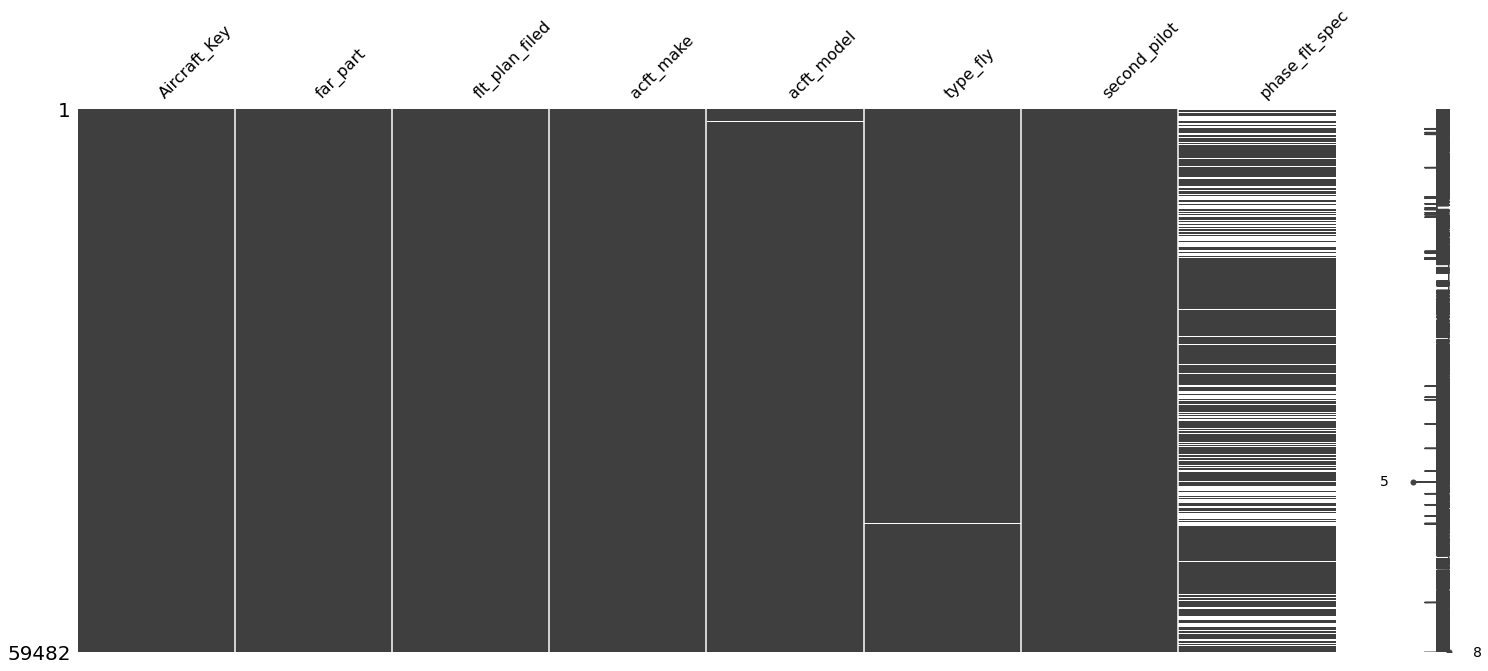

In [17]:
msno.matrix(aircraft_ga_single)
plt.show()

In [18]:
aircraft_ga_single.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59482 entries, 20051031X01758 to 20070927X01454
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Aircraft_Key    59482 non-null  int64 
 1   far_part        59482 non-null  object
 2   flt_plan_filed  59482 non-null  object
 3   acft_make       59477 non-null  object
 4   acft_model      59477 non-null  object
 5   type_fly        59432 non-null  object
 6   second_pilot    59482 non-null  object
 7   phase_flt_spec  43959 non-null  object
dtypes: int64(1), object(7)
memory usage: 4.1+ MB


### Aircrew Dataset

In [19]:
file = 'D:/cap/capstone2/data/raw/crew.csv'
crew = pd.read_csv(file, encoding = 'Windows-1252', index_col = 0, low_memory = False) 

In [20]:
generate_profile(crew)

D:\Anaconda\envs\Capstone2\lib\site-packages\pandas_profiling\visualisation\plot.py:160: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu"))
  cmap.set_bad(cmap_bad)
D:\Anaconda\envs\Capstone2\lib\site-packages\pandas_profiling\visualisation\plot.py:160: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu"))
  cmap.set_bad(cmap_bad)
D:\Anaconda\envs\Capstone2\lib\site-packages\pandas_profiling\visualisation\plot.py:160: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, 

##### Task: Drop unwanted columns

In [21]:
# pc_profession (pilot job) would have been an interesting feature to analyze but it contains to many missing or non-descriptive
# values to be of use

to_drop = ['crew_city', 'crew_res_state', 'crew_res_country', 'crew_inj_level', 'seat_occ_pic', 'pc_profession']
crew.drop(columns = to_drop, inplace=True)

##### Task: Analyse 'Crew Category" column and filter out unwanted records

In [22]:
info(crew, 'crew_category')

UNIQUE VALUES & COUNTS IN crew_category
['PLT  ' 'CPLT ' 'FENG ' nan 'OTHR ' 'KPLT ' 'FLTI ' 'DSTU ' 'PRPS '
 'PASS ' 'CABN ']
PLT      79257
DSTU      2873
FLTI      2383
CPLT      1795
PASS      1075
OTHR       309
PRPS       279
KPLT       145
FENG        70
CABN        40
Name: crew_category, dtype: int64
df shape: 
(88801, 10)


In [23]:
#filter out unwanted pilot categories - retain pilot, student, and empty
crew = crew[~crew['crew_category'].isin(['FLTI ', 'PASS ', 'OTHR ', 'KPLT ', 'PRPS ', 'CPLT ', 'CABN ', 'FENG '])]
info(crew, 'crew_category')

UNIQUE VALUES & COUNTS IN crew_category
['PLT  ' nan 'DSTU ']
PLT      79257
DSTU      2873
Name: crew_category, dtype: int64
df shape: 
(82705, 10)


In [24]:
#standardize unkn entry, replace codes with pilot, student for readeability
crew['crew_category'].fillna('UNK', inplace=True)
crew['crew_category'] = crew['crew_category'].str.strip()
crew['crew_category'] = crew['crew_category'].replace(['PLT', 'DSTU'], ['PILOT','STUDENT'])
info(crew, 'crew_category')

UNIQUE VALUES & COUNTS IN crew_category
['PILOT' 'UNK' 'STUDENT']
PILOT      79257
STUDENT     2873
UNK          575
Name: crew_category, dtype: int64
df shape: 
(82705, 10)


##### Task: eliminate records containing more than one pilot based on crew_number column

In [25]:
info(crew, 'crew_no')

UNIQUE VALUES & COUNTS IN crew_no
[1 2 3 4 5 6]
1    80063
2     2544
3       81
4       12
5        4
6        1
Name: crew_no, dtype: int64
df shape: 
(82705, 10)


In [26]:
#substract multi-crew records from df
multi_crew = crew[crew['crew_no'] > 1]
crew = crew[~crew.crew_no.isin(multi_crew.crew_no)]
crew.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80063 entries, 20001204X00000 to 20200724X65101
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Aircraft_Key    80063 non-null  int64  
 1   crew_no         80063 non-null  int64  
 2   crew_category   80063 non-null  object 
 3   crew_age        76169 non-null  float64
 4   crew_sex        75542 non-null  object 
 5   med_certf       78259 non-null  object 
 6   med_crtf_vldty  74900 non-null  object 
 7   date_lst_med    72485 non-null  object 
 8   bfr             49800 non-null  object 
 9   bfr_date        19163 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 6.7+ MB


<AxesSubplot:xlabel='crew_age'>

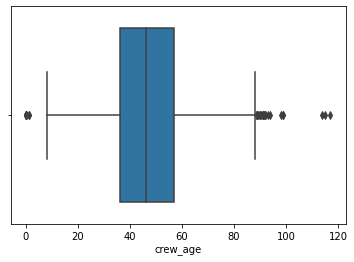

In [27]:
sns.boxplot(crew['crew_age'])

In [28]:
crew['crew_age'].fillna(0, inplace=True)
crew['crew_age'].unique()
info(crew, 'crew_age')

UNIQUE VALUES & COUNTS IN crew_age
[ 42.  53.  39.  25.  38.  43.  63.  59.  66.  33.  46.  31.  68.  50.
  54.  37.  28.  77.  55.  56.  45.  75.  23.  47.  32.  40.  44.  20.
   0.  69.  36.  35.  18.  65.  51.  60.  48.  61.  57.  41.  71.  70.
  64.  72.  29.  34.  26.  49.  58.  22.  30.  27.  73.  74.  62.  67.
  80.  81.  19.  21.  52.  24.  82.  78.  76.  79.  85.  88.  17.  91.
  15.  83.  84.  16.  86.  14.  87.  90.  89.   1.  99.  92.  94. 114.
   8. 115.  98. 117.  93.]
0.0      3901
45.0     1879
46.0     1876
51.0     1865
43.0     1856
         ... 
93.0        1
115.0       1
114.0       1
8.0         1
117.0       1
Name: crew_age, Length: 89, dtype: int64
df shape: 
(80063, 10)


Some age values appear to be out of range. Educated replacement is to limit max age to 100 and minimum age to 14.
The earliest age to be a student pilot is 14 years old. Minimal amount of records are affected.
Ages shown as 0 will be considered as unknown and will be derived later via total flight hour algorithm.

In [29]:
crew['crew_age'] = crew['crew_age'].astype(int)
crew.loc[crew['crew_age'] > 100, 'crew_age'] = 100
crew.loc[(crew['crew_age'] < 14) & (crew['crew_age'] > 0) , 'crew_age'] = 14

###### PENDING TASK

Derive pilot ages using flight hour/experience algorythim to replace '0' ages.

##### Medical Certificate Validity

There are several codes for medical certificate validity. For the purpose of this analysis the categories can be simplified to Valid, Invalid, and Unknown.

In [30]:
crew['med_crtf_vldty'] = crew['med_crtf_vldty'].str.strip()
crew['med_crtf_vldty'].fillna('UNK', inplace=True)
print(crew['med_crtf_vldty'].value_counts())

# To ease analysis will condense categories for medical certificate validity to 'valid', 'invalid', 'unkn'.
crew['med_crtf_vldty'] = crew['med_crtf_vldty'].replace(['VWW', 'VNOW', 'WWL', 'WOWL', 'WTLS'], 'VALID')
crew['med_crtf_vldty'] = crew['med_crtf_vldty'].replace(['NONE', 'EXP', 'NV', 'WOWL'], 'INVALID')
crew['med_crtf_vldty'].value_counts()

VWW     26347
VNOW    24395
WWL     10770
UNK      8076
WOWL     6516
NONE     2147
EXP      1403
NV        302
WTLS      107
Name: med_crtf_vldty, dtype: int64


VALID      68135
UNK         8076
INVALID     3852
Name: med_crtf_vldty, dtype: int64

In [31]:
generate_profile(crew)

D:\Anaconda\envs\Capstone2\lib\site-packages\pandas_profiling\visualisation\plot.py:160: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu"))
  cmap.set_bad(cmap_bad)
D:\Anaconda\envs\Capstone2\lib\site-packages\pandas_profiling\visualisation\plot.py:160: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu"))
  cmap.set_bad(cmap_bad)
D:\Anaconda\envs\Capstone2\lib\site-packages\pandas_profiling\visualisation\plot.py:160: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, 

A biannual flight review is a pilot check conducted every two years for pilot to maintain currency. The bfr column states wheter a pilot had a bfr and the bfr_data shows the date of the last one. Missing value comparison shows that it appears that many entries of dates in 'bfr_date' conincide with missing entries in 'bfr'. Once the dataset is merged and the date on the event is available the 'bfr_date' column can be analyzed to determined if the date was within 2 years of the event and in that case an entry under bfr valid can be made.

#### Aircrew Ratings

Pilots may hold different certifications (ratings) which in turn allows them to conduct certain operations. These certifications show a pilot's level of training.

In [32]:
file = 'D:/cap/capstone2/data/raw/ratings.csv'
ratings = pd.read_csv(file, encoding = 'Windows-1252', low_memory = False) 
#ratings.reset_index()
ratings.index.name = 'idx'

ratings['pilot_key'] = ratings['ev_id'] + ratings['Aircraft_Key'].astype(str) + ratings['crew_no'].astype(str)
to_drop = ['ev_id', 'Aircraft_Key', 'crew_no']          
ratings.drop(columns = to_drop, inplace=True)
ratings = ratings[['pilot_key', 'col_name', 'code']]
ratings.head(20)

,pilot_key,col_name,code
idx,,,
0,20001204X0000011,crew_cert_code,COMM
1,20001204X0000011,crew_rat_airpln,SEL
2,20001204X0000011,crew_rat_airpln,SES
3,20001204X0000011,crew_rat_instruct,NONE
4,20001204X0000011,crew_rat_instrum,APLN
5,20001204X0000011,crew_rat_roto,NONE
6,20001204X0000111,crew_cert_code,ATP
7,20001204X0000111,crew_cert_code,FE
8,20001204X0000111,crew_rat_airpln,MEL


In [33]:
#create new dataframe to transpose data
ratings['code'] = ratings['code'].str.strip()
certs = ratings['code'].unique()
print(certs)

['COMM' 'SEL' 'SES' 'NONE' 'APLN' 'ATP' 'FE' 'MEL' 'MES' 'PRI' 'STU'
 'HELI' 'AME' 'ASE' 'IAIR' 'CFI' 'GLI' 'MIL' 'GYRO' 'BALL' 'IHEL' 'FORN'
 'AIRS' 'REC' 'PLFT' 'SPRT' 'RMPT' 'SUAS']


In [34]:
#create new dataframe to hold boolean 1 / 0 for each possible pilot rating

new_ratings = pd.DataFrame(pd.Series(ratings['pilot_key'].unique()))
new_ratings.rename(columns = {0:'pilot_key'}, inplace=True)

#pilot rating certification
cert_cols = ['CERT_ATP','CERT_REC', 'CERT_CFI', 'CERT_COMM', 'CERT_FE', 'CERT_FORN', 'CERT_MIL', 'CERT_PRI', 
             'CERT_STU', 'CERT_SPRT', 'CERT_RMPT', 'CERT_NONE']
new_ratings[cert_cols] = 0

#airplane ratings
ap_cols = ['AP_MEL', 'AP_MES', 'AP_SEL', 'AP_SES', 'AP_NONE']
new_ratings[ap_cols] = 0

#Instructor Ratings
instr_cols = ['INSTR_AME', 'INSTR_ASE', 'INSTR_GLI', 'INSTR_GYRO', 'INSTR_HELI', 'INSTR_IAIR', 'INSTR_IHEL', 
             'INSTR_PLFT', 'INSTR_SPRT', 'INSTR_NONE']
new_ratings[instr_cols] = 0

#Instrument Ratings
intruc_cols = ['INSTRUM_APLN', 'INSTRUM_HELI', 'INSTRUM_PLFT', 'INSTRUM_NONE']
new_ratings[intruc_cols] = 0

#other raitings
other_cols = ['OTHR_AIRS', 'OTHR_BALL', 'OTHR_GLI', 'OTHR_GYRO', 'OTHR_HELI', 'OTHR_PLFT', 'OTHR_SUAS', 'OTHR_NONE' ]
new_ratings[other_cols] = 0

new_ratings.head()

,pilot_key,CERT_ATP,CERT_REC,CERT_CFI,CERT_COMM,CERT_FE,CERT_FORN,CERT_MIL,CERT_PRI,CERT_STU,...,INSTRUM_PLFT,INSTRUM_NONE,OTHR_AIRS,OTHR_BALL,OTHR_GLI,OTHR_GYRO,OTHR_HELI,OTHR_PLFT,OTHR_SUAS,OTHR_NONE
0,20001204X0000011,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,20001204X0000111,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,20001204X0000211,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,20001204X0000311,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,20001204X0000411,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
cert_atp = ratings[(ratings['col_name'] == 'crew_cert_code') & (ratings['code'] == 'ATP')]
cert_rec = ratings[(ratings['col_name'] == 'crew_cert_code') & (ratings['code'] == 'REC')]
cert_cfi = ratings[(ratings['col_name'] == 'crew_cert_code') & (ratings['code'] == 'CFI')]
cert_comm = ratings[(ratings['col_name'] == 'crew_cert_code') & (ratings['code'] == 'COMM')]
cert_fe = ratings[(ratings['col_name'] == 'crew_cert_code') & (ratings['code'] == 'FE')]
cert_forn = ratings[(ratings['col_name'] == 'crew_cert_code') & (ratings['code'] == 'FORN')]
cert_mil = ratings[(ratings['col_name'] == 'crew_cert_code') & (ratings['code'] == 'MIL')]
cert_none = ratings[(ratings['col_name'] == 'crew_cert_code') & (ratings['code'] == 'NONE')]
cert_pri = ratings[(ratings['col_name'] == 'crew_cert_code') & (ratings['code'] == 'PRI')]
cert_stu = ratings[(ratings['col_name'] == 'crew_cert_code') & (ratings['code'] == 'STU')]
cert_sprt = ratings[(ratings['col_name'] == 'crew_cert_code') & (ratings['code'] == 'SPRT')]


ap_mel = ratings[(ratings['col_name'] == 'crew_rat_airpln') & (ratings['code'] == 'MEL')]
ap_mes = ratings[(ratings['col_name'] == 'crew_rat_airpln') & (ratings['code'] == 'MES')]
ap_sel = ratings[(ratings['col_name'] == 'crew_rat_airpln') & (ratings['code'] == 'SEL')]
ap_ses = ratings[(ratings['col_name'] == 'crew_rat_airpln') & (ratings['code'] == 'SES')]
ap_none = ratings[(ratings['col_name'] == 'crew_rat_airpln') & (ratings['code'] == 'NONE')]

instr_ame = ratings[(ratings['col_name'] == 'crew_rat_instruct') & (ratings['code'] == 'AME')]
instr_ase = ratings[(ratings['col_name'] == 'crew_rat_instruct') & (ratings['code'] == 'ASE')]
instr_gli = ratings[(ratings['col_name'] == 'crew_rat_instruct') & (ratings['code'] == 'GLI')]
instr_gyro = ratings[(ratings['col_name'] == 'crew_rat_instruct') & (ratings['code'] == 'GYRO')]
instr_heli = ratings[(ratings['col_name'] == 'crew_rat_instruct') & (ratings['code'] == 'HELI')]
instr_iair = ratings[(ratings['col_name'] == 'crew_rat_instruct') & (ratings['code'] == 'IAIR')]
instr_ihel = ratings[(ratings['col_name'] == 'crew_rat_instruct') & (ratings['code'] == 'IHEL')]
instr_plft = ratings[(ratings['col_name'] == 'crew_rat_instruct') & (ratings['code'] == 'PLFT')]
instr_sprt = ratings[(ratings['col_name'] == 'crew_rat_instruct') & (ratings['code'] == 'SPRT')]
instr_none = ratings[(ratings['col_name'] == 'crew_rat_instruct') & (ratings['code'] == 'NONE')]

instrum_apln = ratings[(ratings['col_name'] == 'crew_rat_instrum') & (ratings['code'] == 'APLN')]
instrum_heli = ratings[(ratings['col_name'] == 'crew_rat_instrum') & (ratings['code'] == 'HELI')]
instrum_plft = ratings[(ratings['col_name'] == 'crew_rat_instrum') & (ratings['code'] == 'PLFT')]
instrum_none = ratings[(ratings['col_name'] == 'crew_rat_instrum') & (ratings['code'] == 'NONE')]

othr_airs = ratings[(ratings['col_name'] == 'crew_rat_roto') & (ratings['code'] == 'AIRS')]
othr_ball = ratings[(ratings['col_name'] == 'crew_rat_roto') & (ratings['code'] == 'BALL')]
othr_gli = ratings[(ratings['col_name'] == 'crew_rat_roto') & (ratings['code'] == 'GLI')]
othr_gyro = ratings[(ratings['col_name'] == 'crew_rat_roto') & (ratings['code'] == 'GYRO')]
othr_heli = ratings[(ratings['col_name'] == 'crew_rat_roto') & (ratings['code'] == 'HELI')]
othr_plft = ratings[(ratings['col_name'] == 'crew_rat_roto') & (ratings['code'] == 'PLFT')]
othr_suas = ratings[(ratings['col_name'] == 'crew_rat_roto') & (ratings['code'] == 'SUAS')]
othr_none = ratings[(ratings['col_name'] == 'crew_rat_roto') & (ratings['code'] == 'NONE')]

In [35]:
def transcoder(df, cert):
    ''' find match of pilot in df subsets and enter categorical value 1 for that certification
    in the new_ratings df'''
    
    for pilot in df['pilot_key'].tolist():
        new_ratings.loc[new_ratings['pilot_key'] == pilot, cert] = 1

In [36]:
transcoder(cert_atp, 'CERT_ATP')
transcoder(cert_rec, 'CERT_REC')
transcoder(cert_cfi, 'CERT_CFI')
transcoder(cert_comm, 'CERT_COMM')
transcoder(cert_fe, 'CERT_FE')
transcoder(cert_forn, 'CERT_FORN')
transcoder(cert_mil, 'CERT_MIL')
transcoder(cert_none, 'CERT_NONE')
transcoder(cert_pri, 'CERT_PRI')
transcoder(cert_stu, 'CERT_STU')
transcoder(cert_sprt, 'CERT_SPRT')

In [37]:
transcoder(ap_mel, 'AP_MEL')
transcoder(ap_mes, 'AP_MES')
transcoder(ap_sel, 'AP_SEL')
transcoder(ap_ses, 'AP_SES')
transcoder(ap_none, 'AP_NONE')

In [38]:
transcoder(instr_ame, 'INSTR_AME')
transcoder(instr_ase, 'INSTR_ASE')
transcoder(instr_gli, 'INSTR_GLI')
transcoder(instr_gyro, 'INSTR_GYRO')
transcoder(instr_heli, 'INSTR_HELI')
transcoder(instr_iair, 'INSTR_IAIR')
transcoder(instr_ihel, 'INSTR_IHEL')
transcoder(instr_plft, 'INSTR_PLFT')
transcoder(instr_sprt, 'INSTR_SPRT')
transcoder(instr_none, 'INSTR_NONE')

In [39]:
transcoder(instrum_apln, 'INSTRUM_APLN')
transcoder(instrum_heli, 'INSTRUM_HELI')
transcoder(instrum_plft, 'INSTRUM_PLFT')
transcoder(instrum_none, 'INSTRUM_NONE')

In [40]:
transcoder(othr_airs, 'OTHR_AIRS')
transcoder(othr_ball, 'OTHR_BALL')
transcoder(othr_gli, 'OTHR_GLI')
transcoder(othr_gyro, 'OTHR_GYRO')
transcoder(othr_heli, 'OTHR_HELI')
transcoder(othr_plft, 'OTHR_PLFT')
transcoder(othr_suas, 'OTHR_SUAS')
transcoder(othr_none, 'OTHR_NONE')

In [41]:
new_ratings


,pilot_key,CERT_ATP,CERT_REC,CERT_CFI,CERT_COMM,CERT_FE,CERT_FORN,CERT_MIL,CERT_PRI,CERT_STU,...,INSTRUM_PLFT,INSTRUM_NONE,OTHR_AIRS,OTHR_BALL,OTHR_GLI,OTHR_GYRO,OTHR_HELI,OTHR_PLFT,OTHR_SUAS,OTHR_NONE
0,20001204X0000011,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,20001204X0000111,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,20001204X0000211,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,20001204X0000311,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,20001204X0000411,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84575,20200714X7075412,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
84576,20200717X4481911,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
84577,20200719X2195811,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0
84578,20200719X2274611,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1


###### PENDING TASK  - xfield validation
validate certs / rating counts against entries under NONE for category.

##### Pilot Times

Pilot times are a direct measure of experience.

In [35]:
file = 'D:/cap/capstone2/data/raw/crew_time.csv'
times = pd.read_csv(file, encoding = 'Windows-1252', low_memory = False) 
#ratings.reset_index()
times.index.name = 'idx'
times.head()

,ev_id,Aircraft_Key,crew_no,flight_type,flight_craft,flight_hours
idx,,,,,,
0,20001204X00000,1,1,L24H,ALL,6.0
1,20001204X00000,1,1,L30D,ALL,100.0
2,20001204X00000,1,1,L90D,ALL,238.0
3,20001204X00000,1,1,PIC,ALL,5230.0
4,20001204X00000,1,1,TOTL,ALL,5350.0


In [36]:
times['pilot_key'] = times['ev_id'] + times['Aircraft_Key'].astype(str) + times['crew_no'].astype(str)
to_drop = ['ev_id', 'Aircraft_Key', 'crew_no']          
times.drop(columns = to_drop, inplace = True)



times = times[['pilot_key', 'flight_type', 'flight_craft', 'flight_hours']]
times.set_index('pilot_key', inplace = True)

times['flight_craft'] = times['flight_craft'].str.strip()
times['flight_type'] = times['flight_type'].str.strip()

times['time_cat'] = times['flight_craft'] + '-' + times['flight_type']

to_drop = ['flight_type', 'flight_craft'] 


times.drop(columns = to_drop, inplace=True)

times = times[['time_cat', 'flight_hours']]
times.head()

,time_cat,flight_hours
pilot_key,,
20001204X0000011,ALL-L24H,6.0
20001204X0000011,ALL-L30D,100.0
20001204X0000011,ALL-L90D,238.0
20001204X0000011,ALL-PIC,5230.0
20001204X0000011,ALL-TOTL,5350.0


In [37]:
times_cols = times['time_cat'].unique().tolist()
times_cols.sort()
print(times_cols)

['ACTU-INST', 'ACTU-IRCV', 'ACTU-L24H', 'ACTU-L30D', 'ACTU-L90D', 'ACTU-PIC', 'ACTU-TOTL', 'ALL-INST', 'ALL-IRCV', 'ALL-L24H', 'ALL-L30D', 'ALL-L90D', 'ALL-PIC', 'ALL-TOTL', 'GLDR-INST', 'GLDR-IRCV', 'GLDR-L24H', 'GLDR-L30D', 'GLDR-L90D', 'GLDR-PIC', 'GLDR-TOTL', 'INC-NO', 'LTA-INST', 'LTA-IRCV', 'LTA-L24H', 'LTA-L30D', 'LTA-L90D', 'LTA-PIC', 'LTA-TOTL', 'MAKE-INST', 'MAKE-IRCV', 'MAKE-L24H', 'MAKE-L30D', 'MAKE-L90D', 'MAKE-PIC', 'MAKE-TOTL', 'MENG-INST', 'MENG-IRCV', 'MENG-L24H', 'MENG-L30D', 'MENG-L90D', 'MENG-PIC', 'MENG-TOTL', 'NGHT-INST', 'NGHT-IRCV', 'NGHT-L24H', 'NGHT-L30D', 'NGHT-L90D', 'NGHT-PIC', 'NGHT-TOTL', 'REL-NO', 'ROTO-INST', 'ROTO-IRCV', 'ROTO-L24H', 'ROTO-L30D', 'ROTO-L90D', 'ROTO-PIC', 'ROTO-TOTL', 'SENG-INST', 'SENG-IRCV', 'SENG-L24H', 'SENG-L30D', 'SENG-L90D', 'SENG-PIC', 'SENG-TOTL', 'SIMU-INST', 'SIMU-IRCV', 'SIMU-L24H', 'SIMU-L30D', 'SIMU-L90D', 'SIMU-PIC', 'SIMU-TOTL']


In [38]:
new_times = pd.DataFrame(times.index.unique())
new_times.reset_index()
new_times.index.name = 'idx'
new_times.rename(columns = {0:'pilot_key'}, inplace = True)
new_times[times_cols] = 0
new_times.head()


,pilot_key,ACTU-INST,ACTU-IRCV,ACTU-L24H,ACTU-L30D,ACTU-L90D,ACTU-PIC,ACTU-TOTL,ALL-INST,ALL-IRCV,...,SENG-L90D,SENG-PIC,SENG-TOTL,SIMU-INST,SIMU-IRCV,SIMU-L24H,SIMU-L30D,SIMU-L90D,SIMU-PIC,SIMU-TOTL
idx,,,,,,,,,,,,,,,,,,,,,
0,20001204X0000011,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,20001204X0000111,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,20001204X0000211,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,20001204X0000311,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,20001204X0000411,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
times_p = times.pivot(columns='time_cat' , values=['flight_hours'])
times_p.fillna(0, inplace=True)
times_p.head()

flight_hours                                          \
time_cat            ACTU-INST ACTU-IRCV ACTU-L24H ACTU-L30D ACTU-L90D   
pilot_key                                                               
20001204X0000011          0.0       0.0       0.0       0.0       0.0   
20001204X0000111          0.0       0.0       0.0       0.0       0.0   
20001204X0000211          0.0       0.0       0.0      20.0      60.0   
20001204X0000311          0.0       0.0       0.0       0.0       0.0   
20001204X0000411          0.0       0.0       0.0       0.0       0.0   

                                                                ...            \
time_cat         ACTU-PIC ACTU-TOTL ALL-INST ALL-IRCV ALL-L24H  ... SENG-L90D   
pilot_key                                                       ...             
20001204X0000011      0.0       0.0      0.0      0.0      6.0  ...       0.0   
20001204X0000111      0.0    1000.0      0.0      0.0     11.0  ...       0.0   
20001204X0000211    900.0     900.0      0.0      0.0      6.0  ...      20.0   
20001204X0000311      0.0       0.0      0.0      0.0      0.0  ...      13.0   
20001204X0000411      0.0       3.0      0.0      0.0      1.0  ...       0.0   

                                                                             \
time_cat         SENG-PIC SENG-TOTL SIMU-INST SIMU-IRCV SIMU-L24H SIMU-L30D   
pilot_key                                                                     
20001204X0000011      0.0    5350.0       0.0       0.0       0.0       0.0   
20001204X0000111      0.0       0.0       0.0       0.0       0.0       0.0   
20001204X0000211   8150.0    8300.0       0.0       0.0       0.0       0.0   
20001204X0000311    319.0     450.0       0.0       0.0       0.0       0.0   
20001204X0000411    803.0     849.0       0.0       0.0       0.0       0.0   

                                               
time_cat         SIMU-L90D SIMU-PIC SIMU-TOTL  
pilot_key                                      
20001204X0000011       0.0      0.0      50.0  
20001204X0000111       0.0      0.0    1000.0  
20001204X0000211       0.0     40.0      40.0  
20001204X0000311       0.0      0.0      32.0  
20001204X0000411       0.0      0.0      40.0  

[5 rows x 72 columns]

In [47]:
last24_sanity = times_p[times_p['flight_hours']['ACTU-L24H'] > 24]
last24_sanity

flight_hours                                          \
time_cat            ACTU-INST ACTU-IRCV ACTU-L24H ACTU-L30D ACTU-L90D   
pilot_key                                                               
20001213X2694911         66.0       0.0      66.0      66.0      66.0   
20001213X3431211          0.0       0.0     175.0       0.0      10.0   
20021230X0564111          0.0       0.0      56.0      56.0       0.0   

                                                                ...            \
time_cat         ACTU-PIC ACTU-TOTL ALL-INST ALL-IRCV ALL-L24H  ... SENG-L90D   
pilot_key                                                       ...             
20001213X2694911     66.0      66.0      0.0      0.0      3.0  ...     147.0   
20001213X3431211      0.0     175.0      0.0      0.0      6.0  ...     150.0   
20021230X0564111     25.0      25.0      0.0      0.0     56.0  ...      56.0   

                                                                             \
time_cat         SENG-PIC SENG-TOTL SIMU-INST SIMU-IRCV SIMU-L24H SIMU-L30D   
pilot_key                                                                     
20001213X2694911   2127.0    2327.0      37.0       0.0      37.0      37.0   
20001213X3431211   1338.0    1350.0       0.0       0.0      75.0       0.0   
20021230X0564111   9818.0    9818.0       0.0       0.0       0.0       0.0   

                                               
time_cat         SIMU-L90D SIMU-PIC SIMU-TOTL  
pilot_key                                      
20001213X2694911      37.0     37.0      37.0  
20001213X3431211       0.0      0.0      90.0  
20021230X0564111       0.0      0.0       0.0  

[3 rows x 72 columns]

###### Pending Task - need to validate times.

Some times are unrealisticaly high for measured parameters.

#####  Events table

Event Type (accident vs. incident), date, light condition, general weather conditions, injury level

In [40]:
file = 'D:/cap/capstone2/data/raw/event.csv'
event = pd.read_csv(file, encoding = 'Windows-1252', low_memory = False) 
#ratings.reset_index()
event.index.name = 'idx'
event.head()

,ev_id,ev_type,ev_date,ev_time,ev_tmzn,ev_city,ev_state,ev_country,mid_air,on_ground_collision,...,wind_dir_ind,wind_vel_kts,wind_vel_ind,gust_ind,gust_kts,altimeter,wx_dens_alt,wx_int_precip,ev_highest_injury,wx_cond_basic
idx,,,,,,,,,,,,,,,,,,,,,
0,20001204X00000,ACC,1/10/1999 0:00:00,1330.0,AST,QUINHAGAK,AK,USA,N,N,...,U,5.0,UNK,U,0.0,NaN,NaN,UNK,MINR,VMC
1,20001204X00001,INC,1/19/1999 0:00:00,326.0,AST,FAIRBANKS,AK,USA,N,N,...,U,0.0,CALM,U,0.0,NaN,NaN,UNK,NONE,VMC
2,20001204X00002,ACC,1/5/1999 0:00:00,1425.0,AST,ANCHORAGE,AK,USA,N,N,...,U,4.0,UNK,N,0.0,30.0,NaN,UNK,NONE,VMC
3,20001204X00003,ACC,1/10/1999 0:00:00,1351.0,AST,BETHEL,AK,USA,N,N,...,U,10.0,UNK,U,0.0,29.0,NaN,LGT,NONE,IMC
4,20001204X00004,ACC,1/12/1999 0:00:00,1050.0,AST,CHEVAK,AK,USA,N,N,...,U,12.0,UNK,N,0.0,28.0,NaN,UNK,NONE,VMC


In [41]:
cols = event.columns
cols

Index(['ev_id', 'ev_type', 'ev_date', 'ev_time', 'ev_tmzn', 'ev_city',
       'ev_state', 'ev_country', 'mid_air', 'on_ground_collision',
       'wx_brief_comp', 'wx_src_iic', 'light_cond', 'sky_cond_nonceil',
       'sky_nonceil_ht', 'sky_ceil_ht', 'sky_cond_ceil', 'vis_rvr', 'vis_rvv',
       'vis_sm', 'wx_temp', 'wx_dew_pt', 'wind_dir_deg', 'wind_dir_ind',
       'wind_vel_kts', 'wind_vel_ind', 'gust_ind', 'gust_kts', 'altimeter',
       'wx_dens_alt', 'wx_int_precip', 'ev_highest_injury', 'wx_cond_basic'],
      dtype='object')

In [42]:
to_drop = ['ev_time', 'ev_tmzn', 'ev_city', 'ev_state', 'wx_brief_comp', 'wx_src_iic', 'sky_cond_nonceil',
           'sky_nonceil_ht', 'sky_ceil_ht', 'sky_cond_ceil', 'vis_rvr', 'vis_rvv', 'vis_sm', 'wx_temp', 
           'wx_dew_pt', 'wind_dir_deg', 'wind_dir_ind', 'wind_vel_kts', 'wind_vel_ind', 'gust_ind', 'gust_kts',
           'altimeter', 'wx_dens_alt', 'wx_int_precip']

event.drop(columns = to_drop, inplace = True)
event

,ev_id,ev_type,ev_date,ev_country,mid_air,on_ground_collision,light_cond,ev_highest_injury,wx_cond_basic
idx,,,,,,,,,
0,20001204X00000,ACC,1/10/1999 0:00:00,USA,N,N,DAYL,MINR,VMC
1,20001204X00001,INC,1/19/1999 0:00:00,USA,N,N,NDRK,NONE,VMC
2,20001204X00002,ACC,1/5/1999 0:00:00,USA,N,N,DAYL,NONE,VMC
3,20001204X00003,ACC,1/10/1999 0:00:00,USA,N,N,DAYL,NONE,IMC
4,20001204X00004,ACC,1/12/1999 0:00:00,USA,N,N,DAWN,NONE,VMC
...,...,...,...,...,...,...,...,...,...
84082,20200727X40311,NaN,7/27/2020 0:00:00,USA,N,N,NaN,NaN,NaN
84083,20200727X90604,ACC,7/27/2020 0:00:00,USA,N,N,DAYL,NONE,VMC
84084,20200728X14620,ACC,7/28/2020 0:00:00,USA,N,N,NaN,NaN,NaN


In [43]:
generate_profile(event)

In [65]:
print(min(event['ev_date']))

1/1/1982 0:00:00


#### Findings Table

Coded reasons for accident as determined by investigation.

In [128]:
file = 'D:/cap/capstone2/data/raw/findings.csv'
findings = pd.read_csv(file, encoding = 'Windows-1252', low_memory = False) 
#ratings.reset_index()
findings.index.name = 'idx'
findings.head()

,ev_id,Aircraft_Key,finding_no,finding_description,category_no,subcategory_no,section_no,subsection_no,modifier_no,Cause_Factor
idx,,,,,,,,,,
0,20001208X08803,1,1,Personnel issues-Action/decision-Info processing/decision-Decision making/judgment-Pilot - C,2,4,15,20,44,C
1,20001208X08803,1,2,Environmental issues-Conditions/weather/phenomena-Ceiling/visibility/precip-Below VFR minima-Decision related to condition - C,3,3,50,75,84,C
2,20001208X08803,1,3,Environmental issues-Conditions/weather/phenomena-Ceiling/visibility/precip-Below VFR minima-Effect on operation - C,3,3,50,75,82,C
3,20001208X08803,1,4,Aircraft-Aircraft oper/perf/capability-Performance/control parameters-Altitude-Not attained/maintained - C,1,6,20,12,20,C
4,20001208X08803,1,5,Aircraft-Aircraft oper/perf/capability-Performance/control parameters-(general)-Not attained/maintained - C,1,6,20,0,20,C


In [129]:
#Remove records with category_no = 5 (accident reason not determined)
not_determined_idx = findings[findings['category_no'] == 5].index
findings.drop(not_determined_idx, inplace = True)

In [130]:
#slice out category out of description



findings.insert(loc=5, column='cat_descript', value = "" )
findings.insert(loc=7, column='sub_descript', value = "" )
findings.insert(loc=9, column='sec_descript', value = "" )
findings.insert(loc=11, column='subsec_descript', value = "" )
findings.insert(loc=13, column='mod_descript', value = "" )



#findings.cat_descript[findings.category_no == 2] = 'Personnel issues'
#findings.cat_descript[findings.category_no == 1] = 'Aircraft'
#findings.cat_descript[findings.category_no == 3] = 'Environmental issues'
#findings.cat_descript[findings.category_no == 4] = 'Organizational issues'


findings

,ev_id,Aircraft_Key,finding_no,finding_description,category_no,cat_descript,subcategory_no,sub_descript,section_no,sec_descript,subsection_no,subsec_descript,modifier_no,mod_descript,Cause_Factor
idx,,,,,,,,,,,,,,,
0,20001208X08803,1,1,Personnel issues-Action/decision-Info processing/decision-Decision making/judgment-Pilot - C,2,,4,,15,,20,,44,,C
1,20001208X08803,1,2,Environmental issues-Conditions/weather/phenomena-Ceiling/visibility/precip-Below VFR minima-Decision related to condition - C,3,,3,,50,,75,,84,,C
2,20001208X08803,1,3,Environmental issues-Conditions/weather/phenomena-Ceiling/visibility/precip-Below VFR minima-Effect on operation - C,3,,3,,50,,75,,82,,C
3,20001208X08803,1,4,Aircraft-Aircraft oper/perf/capability-Performance/control parameters-Altitude-Not attained/maintained - C,1,,6,,20,,12,,20,,C
4,20001208X08803,1,5,Aircraft-Aircraft oper/perf/capability-Performance/control parameters-(general)-Not attained/maintained - C,1,,6,,20,,0,,20,,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47512,20200420X94606,1,1,Personnel issues-Task performance-Use of equip/info-Aircraft control-Pilot - C,2,,6,,30,,40,,44,,C
47513,20200420X94606,1,2,Aircraft-Aircraft oper/perf/capability-Performance/control parameters-Directional control-Not attained/maintained - C,1,,6,,20,,20,,20,,C
47514,20200420X94606,1,3,Environmental issues-Physical environment-Runway/land/takeoff/taxi surface-Soft surface-Effect on operation - C,3,,2,,30,,20,,82,,C


In [131]:

#for d in findings['finding_description']:
df_len = len(findings)

for r in range (0, df_len):
    try:
        d = findings.loc[r,'finding_description']
        res = [i.start() for i in re.finditer('-', d)]
        
        
        
        findings.loc[r,'cat_descript'] = d[:res[0]]
        findings.loc[r,'sub_descript'] = d[res[0] + 1 :res[1]]
        findings.loc[r,'sec_descript'] = d[res[1] + 1 :res[2]]
        findings.loc[r,'subsec_descript'] = d[res[2] + 1 :res[3]]
        findings.loc[r,'mod_descript'] = d[res[3] + 1 :]
    except Exception:
        continue
    
  
findings    
    

,ev_id,Aircraft_Key,finding_no,finding_description,category_no,cat_descript,subcategory_no,sub_descript,section_no,sec_descript,subsection_no,subsec_descript,modifier_no,mod_descript,Cause_Factor
idx,,,,,,,,,,,,,,,
0,20001208X08803,1,1,Personnel issues-Action/decision-Info processing/decision-Decision making/judgment-Pilot - C,2,Personnel issues,4,Action/decision,15,Info processing/decision,20,Decision making/judgment,44,Pilot - C,C
1,20001208X08803,1,2,Environmental issues-Conditions/weather/phenomena-Ceiling/visibility/precip-Below VFR minima-Decision related to condition - C,3,Environmental issues,3,Conditions/weather/phenomena,50,Ceiling/visibility/precip,75,Below VFR minima,84,Decision related to condition - C,C
2,20001208X08803,1,3,Environmental issues-Conditions/weather/phenomena-Ceiling/visibility/precip-Below VFR minima-Effect on operation - C,3,Environmental issues,3,Conditions/weather/phenomena,50,Ceiling/visibility/precip,75,Below VFR minima,82,Effect on operation - C,C
3,20001208X08803,1,4,Aircraft-Aircraft oper/perf/capability-Performance/control parameters-Altitude-Not attained/maintained - C,1,Aircraft,6,Aircraft oper/perf/capability,20,Performance/control parameters,12,Altitude,20,Not attained/maintained - C,C
4,20001208X08803,1,5,Aircraft-Aircraft oper/perf/capability-Performance/control parameters-(general)-Not attained/maintained - C,1,Aircraft,6,Aircraft oper/perf/capability,20,Performance/control parameters,0,(general),20,Not attained/maintained - C,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47512,20200420X94606,1,1,Personnel issues-Task performance-Use of equip/info-Aircraft control-Pilot - C,2,,6,,30,,40,,44,,C
47513,20200420X94606,1,2,Aircraft-Aircraft oper/perf/capability-Performance/control parameters-Directional control-Not attained/maintained - C,1,,6,,20,,20,,20,,C
47514,20200420X94606,1,3,Environmental issues-Physical environment-Runway/land/takeoff/taxi surface-Soft surface-Effect on operation - C,3,,2,,30,,20,,82,,C


In [121]:
generate_profile(findings)

D:\Anaconda\envs\Capstone2\lib\site-packages\pandas_profiling\visualisation\plot.py:160: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu"))
  cmap.set_bad(cmap_bad)
D:\Anaconda\envs\Capstone2\lib\site-packages\pandas_profiling\visualisation\plot.py:160: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu"))
  cmap.set_bad(cmap_bad)
D:\Anaconda\envs\Capstone2\lib\site-packages\pandas_profiling\visualisation\plot.py:160: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, 

In [132]:
pd.set_option('display.max_colwidth', -1)
mt_cat = findings[findings['cat_descript'] == '']
print(len(mt_cat['finding_description']))

1538


<ipython-input-132-643630765453>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [86]:
aircraft_find = findings[findings['category_no'] == 1]
modifiers = aircraft_find.modifier_no.unique()
modifiers

array([20, 13,  6,  8,  1,  2, 99,  5, 11, 21, 15, 14,  7, 18, 26, 12, 24,
       25, 10, 23, 17,  9, 16, 22, 19,  3, 27], dtype=int64)

#### TABLE MERGE TEST

In [49]:
rated_time = pd.merge(new_ratings, times_p, how='left', on = 'pilot_key')
rated_time

D:\Anaconda\envs\Capstone2\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


,pilot_key,CERT_ATP,CERT_REC,CERT_CFI,CERT_COMM,CERT_FE,CERT_FORN,CERT_MIL,CERT_PRI,CERT_STU,...,"(flight_hours, SENG-L90D)","(flight_hours, SENG-PIC)","(flight_hours, SENG-TOTL)","(flight_hours, SIMU-INST)","(flight_hours, SIMU-IRCV)","(flight_hours, SIMU-L24H)","(flight_hours, SIMU-L30D)","(flight_hours, SIMU-L90D)","(flight_hours, SIMU-PIC)","(flight_hours, SIMU-TOTL)"
0,20001204X0000011,0,0,0,1,0,0,0,0,0,...,0.0,0.0,5350.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0
1,20001204X0000111,1,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0
2,20001204X0000211,1,0,0,1,0,0,0,0,0,...,20.0,8150.0,8300.0,0.0,0.0,0.0,0.0,0.0,40.0,40.0
3,20001204X0000311,0,0,0,0,0,0,0,1,0,...,13.0,319.0,450.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0
4,20001204X0000411,0,0,0,1,0,0,0,0,0,...,0.0,803.0,849.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84575,20200714X7075412,0,0,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84576,20200717X4481911,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84577,20200719X2195811,0,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84578,20200719X2274611,0,0,0,0,0,0,0,1,0,...,8.4,267.6,309.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0
